In [201]:
# import generales
try:
    import pandas as pd
except ImportError as err:
    !pip install pandas
    import pandas as pd

try:
    import numpy as np
except ImportError as err:
    !pip install numpy
    import numpy as np




try:
    import matplotlib.pyplot as plt
except ImportError as err:
    !pip install matplotlib
    import matplotlib.pyplot as plt

import os

# Asegurarnos de usar Keras 3 con backend TensorFlow
# Es necesario hacerlo antes de cargar Keras
os.environ["KERAS_BACKEND"] = "tensorflow"

# Importaciones de Keras y TensorFlow
try:
    import keras
except ImportError as err:
    !pip install keras
    import keras

try:
    import tensorflow as tf 
except ImportError as err:
    !pip install tensorflow
    import tensorflow as tf 



from keras.layers import Normalization,GRU, TimeDistributed,RepeatVector,Input, Dense, LSTM

## Dataset

In [26]:
trainset=pd.read_csv("./datasets/train_without_anomaly.csv")
testset_sin_anomalias=pd.read_csv("./datasets/test_without_anomaly.csv")#solo para visualización
testset=pd.read_csv("./datasets/test_with_anomaly.csv")

In [28]:
print("Datos de entrenamiento:")
print(trainset.head())


print("Datos de test:")
print(testset.head())

Datos de entrenamiento:
   Sensor1_HumedadEntrada  Sensor2_TemperaturaGases  Output_HumedadSalida
0                0.775731                156.917438              0.077245
1                0.812161                148.645725              0.061767
2                0.738365                140.334998              0.096976
3                0.681176                142.090015              0.300313
4                0.699174                148.634488              0.432266
Datos de test:
   Sensor1_HumedadEntrada  Sensor2_TemperaturaGases  Output_HumedadSalida  \
0                0.815679                160.875974              0.074051   
1                0.784431                149.033159              0.066119   
2                0.764329                142.087646              0.109464   
3                0.705300                142.220004              0.211212   
4                0.634251                146.115705              0.456451   

   Es_Anomalia  
0        False  
1        False  
2  

### Visualización de los datos

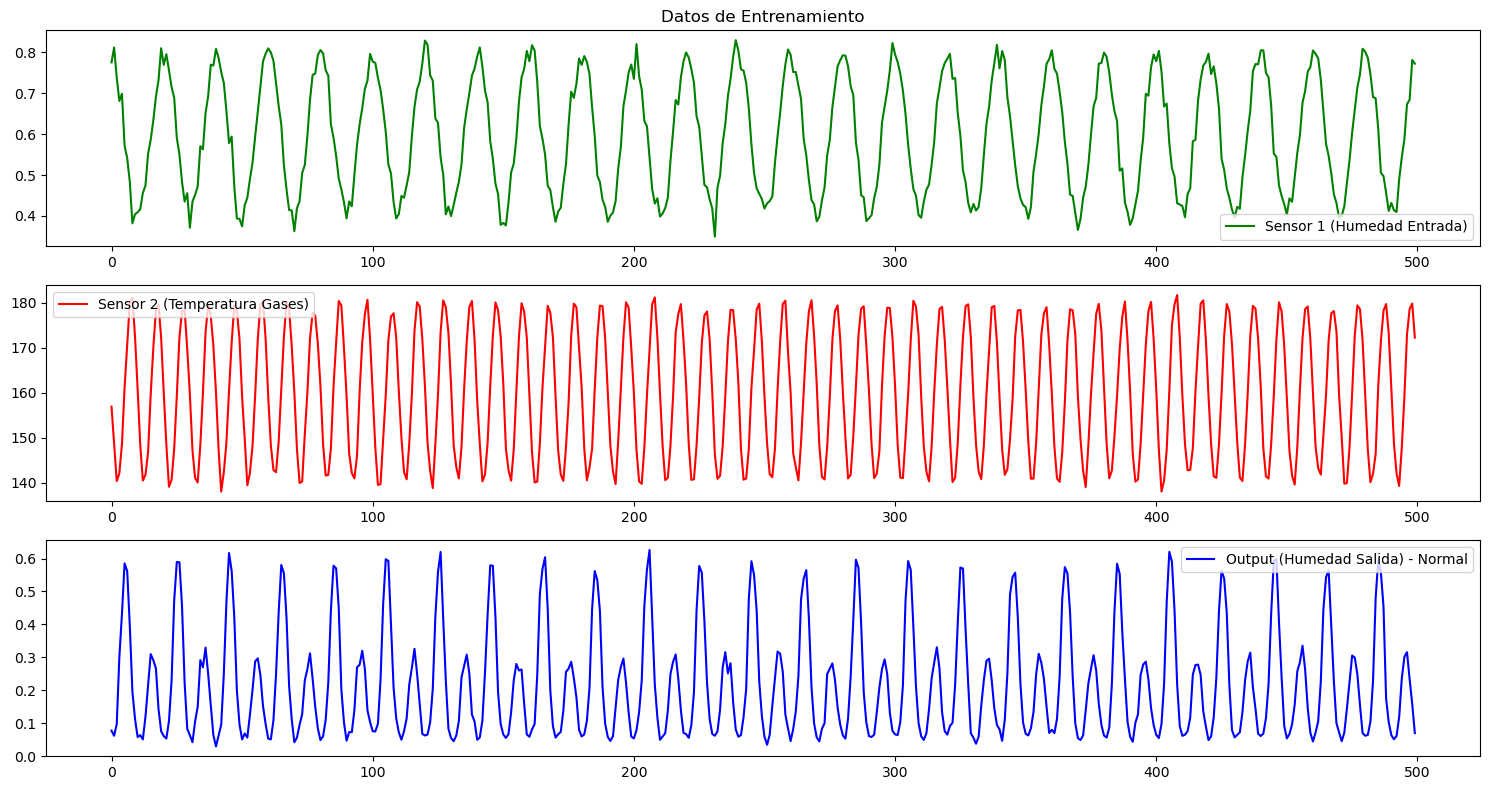

In [29]:
# Visualizar datos de entrenamiento (sensores y salida)
plt.figure(figsize=(15, 8))
plt.subplot(3,1,1)
plt.plot(trainset['Sensor1_HumedadEntrada'][:500], label='Sensor 1 (Humedad Entrada)',color='green')
plt.title('Datos de Entrenamiento')
plt.legend()
plt.subplot(3,1,2)
plt.plot(trainset['Sensor2_TemperaturaGases'][:500], label='Sensor 2 (Temperatura Gases)', color='red')
plt.legend()
plt.subplot(3,1,3)
plt.plot(trainset['Output_HumedadSalida'][:500], label='Output (Humedad Salida) - Normal', color='blue')
plt.legend()
plt.tight_layout()
plt.show()

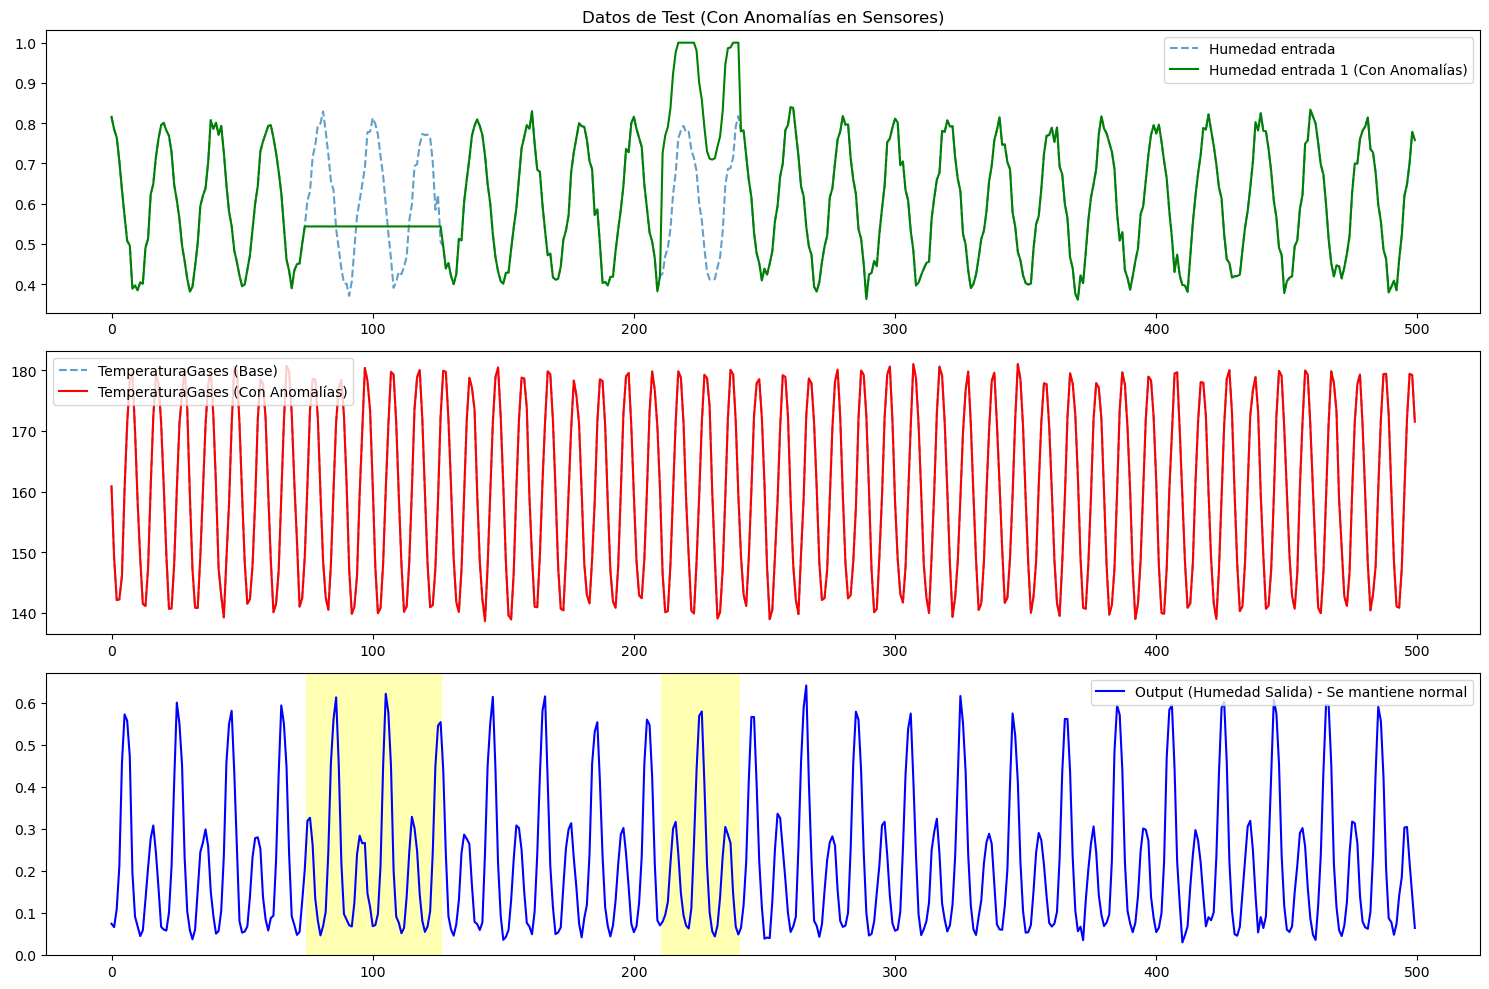

In [30]:
# Visualizar datos de test (con anomalías en sensores vs salida normal)
plt.figure(figsize=(15, 10))
plt.subplot(3,1,1)
plt.plot(testset_sin_anomalias['Sensor1_HumedadEntrada'], label='Humedad entrada ', linestyle='--', alpha=0.7)
plt.plot(testset['Sensor1_HumedadEntrada'], label='Humedad entrada 1 (Con Anomalías)', color='green')
plt.title('Datos de Test (Con Anomalías en Sensores)')
plt.legend()

plt.subplot(3,1,2)
plt.plot(testset_sin_anomalias['Sensor2_TemperaturaGases'], label='TemperaturaGases (Base)', linestyle='--', alpha=0.7)
plt.plot(testset['Sensor2_TemperaturaGases'], label='TemperaturaGases (Con Anomalías)', color='red')
plt.legend()

plt.subplot(3,1,3)
plt.plot(testset['Output_HumedadSalida'], label='Output (Humedad Salida) - Se mantiene normal', color='blue')
# Marcar zonas de anomalía para referencia visual
anomaly_zones = testset_sin_anomalias[testset['Es_Anomalia']].index
for idx in anomaly_zones:
    plt.axvspan(idx - 0.5, idx + 0.5, color='yellow', alpha=0.3, lw=0)
plt.legend()
plt.tight_layout()
plt.show()

### Preprocesado de datos

In [223]:
# Normalize and save the mean and std we get,
# for normalizing test data.
training_mean = trainset.mean()
training_std = trainset.std()
trainset=(trainset - training_mean) / training_std
testset=(testset- training_mean) / training_std



In [39]:
normalization_layer = Normalization(axis=-1)
normalization_layer.adapt(trainset.values) # ajustar SOLO con datos de entrenamiento las características de entrada
denormalization_layer=Normalization(mean=normalization_layer.mean, variance=normalization_layer.variance, invert=True)

In [23]:
trainset.head()

,Sensor1_HumedadEntrada,Sensor2_TemperaturaGases,Output_HumedadSalida,Sensor1_Scaled,Sensor2_Scaled
0,0.775731,156.917438,0.077245,0.863973,0.439351
1,0.812161,148.645725,0.061767,0.936770,0.253685
2,0.738365,140.334998,0.096976,0.789306,0.067143
3,0.681176,142.090015,0.300313,0.675029,0.106536
4,0.699174,148.634488,0.432266,0.710993,0.253433


## Preparación de las secuencias

In [224]:
#no podemos emplear keras.utils.timeseries_dataset_from_array porque no genera secuencias para la salida (targets)
WINDOW_SIZE=5
NUM_INPUTS=3

def crear_secuencias(data, window_size):
    X = []
    for i in range(len(data) - window_size + 1):
        X.append(data[i:(i + window_size)])
    return np.array(X)

# Crear secuencias para entrenamiento y test
# El autoencoder intentará reconstruir la ventana completa, o el último punto de la ventana.
# Para este caso, vamos a reconstruir la ventana completa.
X_train_seq = crear_secuencias(trainset, WINDOW_SIZE)
X_test_seq = crear_secuencias(testset[["Sensor1_HumedadEntrada","Sensor2_TemperaturaGases","Output_HumedadSalida"]], WINDOW_SIZE)

print("Forma de secuencias de entrenamiento:", X_train_seq.shape) # (samples, window_size, n_features)
print("Forma de secuencias de test:", X_test_seq.shape)

Forma de secuencias de entrenamiento: (2996, 5, 3)
Forma de secuencias de test: (496, 5, 3)


In [186]:
print(X_train_seq[0])

[[7.75730733e-01 1.56917438e+02 7.72452502e-02]
 [8.12161003e-01 1.48645725e+02 6.17673489e-02]
 [7.38364720e-01 1.40334998e+02 9.69755519e-02]
 [6.81176030e-01 1.42090015e+02 3.00313251e-01]
 [6.99173943e-01 1.48634488e+02 4.32265845e-01]]


## Creación del modelo

In [116]:
from keras.models import Model
# define the autoencoder network model
def autoencoder_model(X):
    inputs = Input(shape=(X.shape[1], X.shape[2]))
    L1 = GRU(48, activation='relu', return_sequences=True)(inputs)
    L2 = GRU(12, activation='relu', return_sequences=True)(L1)
    L3 = GRU(6, activation='relu', return_sequences=False)(L2)
    L4 = RepeatVector(X.shape[1])(L3)
    L5 = GRU(6, activation='relu', return_sequences=True)(L4)
    L6 = GRU(12, activation='relu', return_sequences=True)(L5)
    L7 = GRU(48, activation='relu', return_sequences=True)(L6)
    output = TimeDistributed(Dense(X.shape[2]))(L7)    
    model = Model(inputs=inputs, outputs=output)
    return model


aux=autoencoder_model(X_train_seq)
aux.summary()

Model: "functional_96"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 10, 3)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_71 (GRU)                    │ (None, 10, 48)         │         7,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_72 (GRU)                    │ (None, 10, 12)         │         2,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_73 (GRU)                    │ (None, 6)              │           360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_13 (RepeatVector) │ (None, 10, 6)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_74 (GRU)                    │ (None, 10, 6)          │           252 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_75 (GRU)                    │ (None, 10, 12)         │           720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_76 (GRU)                    │ (None, 10, 48)         │         8,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_6              │ (None, 10, 3)          │           147 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,271 (79.18 KB)

 Trainable params: 20,271 (79.18 KB)

 Non-trainable params: 0 (0.00 B)

In [225]:
def get_model(seq_len, num_model_features, normalization_layer, denormalization_layer, name_model,units=[48,24,12]):
    #input layer

    model = keras.Sequential(name=name_model)
    model.add( keras.Input(shape=(seq_len, num_model_features), name="input_layer"))
    #model.add(normalization_layer)
    num_layer=0
    for num_layer,layer_units in enumerate(units[:-1]):
        model.add(LSTM(layer_units, activation='relu', return_sequences=True, name=f"L_{num_layer}"))

    num_layer+=1
    model.add(LSTM( units[-1], activation='relu', return_sequences=False,name=f"L_{num_layer}"))
    num_layer+=1
    model.add(RepeatVector(seq_len,name=f"L_{num_layer}"))
    for num_layer, layer_units in enumerate(units[::-1], start=num_layer+1):
        model.add(LSTM(layer_units, activation='relu', return_sequences=True,name=f"L_{num_layer}"))
    num_layer+=1
    model.add(TimeDistributed(Dense(num_model_features),name=f"L_{num_layer}"))
    #model.add(denormalization_layer)
    return model
    
              
    

In [226]:
autoencoder=get_model(WINDOW_SIZE,NUM_INPUTS, normalization_layer, denormalization_layer,"autoencoder_GRU", units=[24,12,6])
autoencoder.summary()

Model: "autoencoder_GRU"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ L_0 (LSTM)                      │ (None, 5, 24)          │         2,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ L_1 (LSTM)                      │ (None, 5, 12)          │         1,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ L_2 (LSTM)                      │ (None, 6)              │           456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ L_3 (RepeatVector)              │ (None, 5, 6)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ L_4 (LSTM)                      │ (None, 5, 6)           │           312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ L_5 (LSTM)                      │ (None, 5, 12)          │           912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ L_6 (LSTM)                      │ (None, 5, 24)          │         3,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ L_7 (TimeDistributed)           │ (None, 5, 3)           │            75 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,771 (38.17 KB)

 Trainable params: 9,771 (38.17 KB)

 Non-trainable params: 0 (0.00 B)

## Compilación del modelo

In [227]:
autoencoder.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss='mse') # Mean Squared Error para reconstrucción
#aux.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss='mse') # Mean Squared Error para reconstrucción

## Entrenamiento del modelo

In [228]:
callback_early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10, # Número de épocas sin mejora antes de detener
    restore_best_weights=True # Restaurar los pesos del modelo de la mejor época
)

history = autoencoder.fit(X_train_seq,X_train_seq,    epochs=50, batch_size=32,validation_split=0.1 ,callbacks=[callback_early_stopping]  )

Epoch 1/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.9968 - val_loss: 0.9965
Epoch 2/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.9407 - val_loss: 0.7451
Epoch 3/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.6902 - val_loss: 0.4330
Epoch 4/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3428 - val_loss: 0.1836
Epoch 5/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1684 - val_loss: 0.1033
Epoch 6/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0847 - val_loss: 0.0573
Epoch 7/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0509 - val_loss: 0.0403
Epoch 8/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0380 - val_loss: 0.0307
Epoch 9/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0277 - val_loss: 0.0258
Epoch 10/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0239 - val_loss: 0.0223
Epoch 11/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0216 - val_loss: 0.0206
Epoch 12/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0191 - val_l

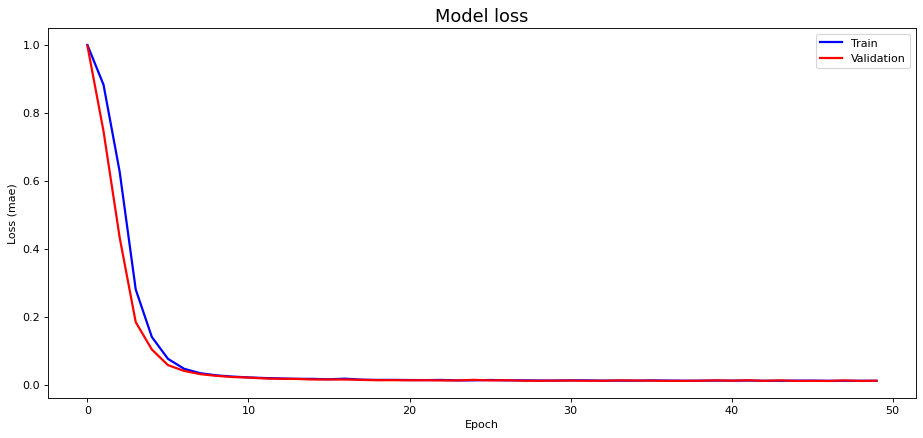

In [229]:
# plot the training losses
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(history.history['loss'], 'b', label='Train', linewidth=2)
ax.plot(history.history['val_loss'], 'r', label='Validation', linewidth=2)
ax.set_title('Model loss', fontsize=16)
ax.set_ylabel('Loss (mae)')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()

## Detección de anomalías






16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step 


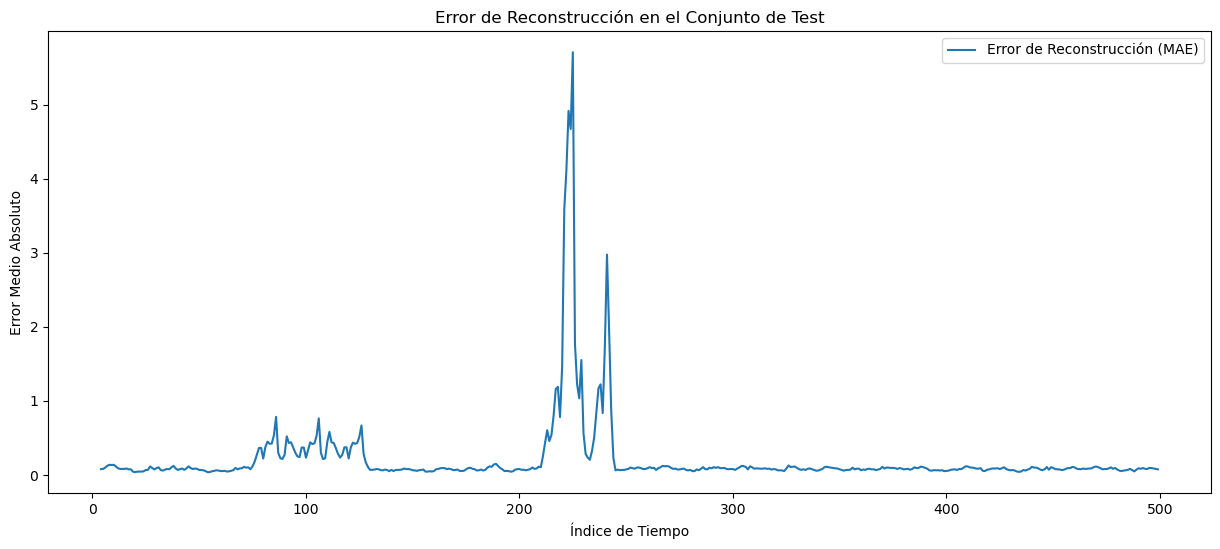

In [230]:
X_test_pred_seq = autoencoder.predict(X_test_seq)

# Calcular el error de reconstrucción (MAE o MSE) para cada secuencia
# Suma de errores absolutos o cuadrados a lo largo de las características y la ventana
reconstruction_errors = np.mean(np.abs(X_test_seq - X_test_pred_seq), axis=(1,2)) # MAE por secuencia
# Opcional: MSE
# reconstruction_errors_mse = np.mean(np.square(X_test_seq - X_test_pred_seq), axis=(1,2))

# Para alinear los errores con el dataframe original, necesitamos tener en cuenta el window_size
# El error de reconstrucción para la secuencia que TERMINA en el tiempo `t` se asocia con `t`.
df_test_analysis = testset.iloc[WINDOW_SIZE-1:].copy()
df_test_analysis['Reconstruction_Error'] = reconstruction_errors

plt.figure(figsize=(15, 6))
plt.plot(df_test_analysis.index, df_test_analysis['Reconstruction_Error'], label='Error de Reconstrucción (MAE)')
plt.title('Error de Reconstrucción en el Conjunto de Test')
plt.xlabel('Índice de Tiempo')
plt.ylabel('Error Medio Absoluto')
plt.legend()
plt.show()

Umbral de anomalía establecido (MAE): 0.6199


KeyError: "None of [Index([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,\n       ...\n       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],\n      dtype='float64', length=500)] are in the [columns]"

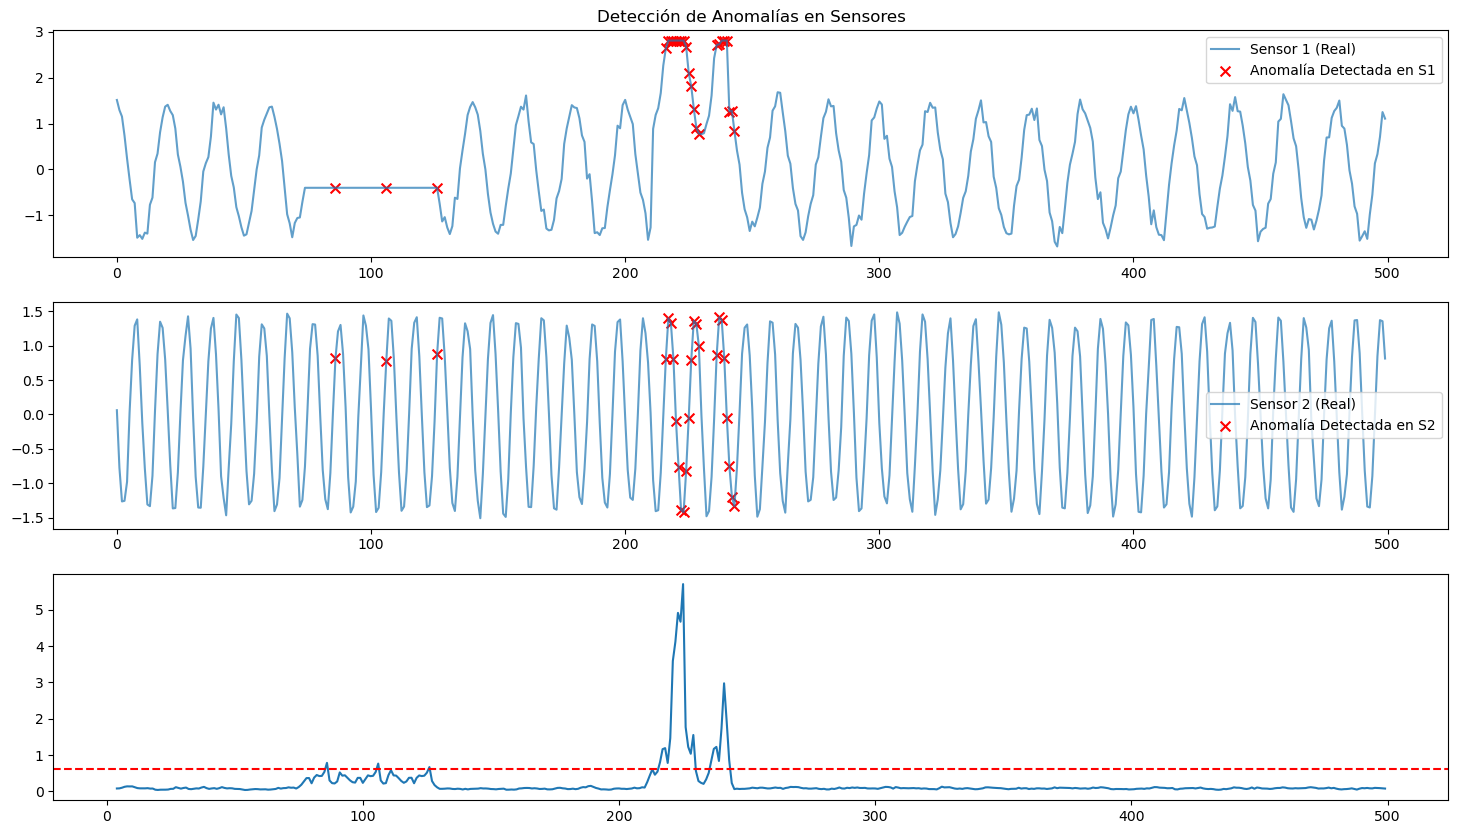

In [231]:
# Umbral simple: basado en un percentil del error de reconstrucción en los datos de test
# (Idealmente, se usaría un conjunto de validación normal para esto)
UMBRAL_ANOMALIA = np.percentile(reconstruction_errors, 98) # Ej: 90º percentil como umbral
print(f"Umbral de anomalía establecido (MAE): {UMBRAL_ANOMALIA:.4f}")

df_test_analysis['Anomalia_Detectada'] = df_test_analysis['Reconstruction_Error'] > UMBRAL_ANOMALIA

# Visualizar detecciones
plt.figure(figsize=(18, 10))

plt.subplot(3,1,1)
plt.plot(testset.index, testset['Sensor1_HumedadEntrada'], label='Sensor 1 (Real)', alpha=0.7)
plt.scatter(df_test_analysis[df_test_analysis['Anomalia_Detectada']].index,
            testset.loc[df_test_analysis[df_test_analysis['Anomalia_Detectada']].index, 'Sensor1_HumedadEntrada'],
            color='red', label='Anomalía Detectada en S1', marker='x', s=50)
plt.title('Detección de Anomalías en Sensores')
plt.legend()

plt.subplot(3,1,2)
plt.plot(testset.index, testset['Sensor2_TemperaturaGases'], label='Sensor 2 (Real)', alpha=0.7)
plt.scatter(df_test_analysis[df_test_analysis['Anomalia_Detectada']].index,
            testset.loc[df_test_analysis[df_test_analysis['Anomalia_Detectada']].index, 'Sensor2_TemperaturaGases'],
            color='red', label='Anomalía Detectada en S2', marker='x', s=50)
plt.legend()

plt.subplot(3,1,3)
plt.plot(df_test_analysis.index, df_test_analysis['Reconstruction_Error'], label='Error de Reconstrucción (MAE)')
plt.axhline(UMBRAL_ANOMALIA, color='r', linestyle='--', label='Umbral')
# Marcar las anomalías reales para comparación visual
true_anomalies_indices = testset[testset['Es_Anomalia']].index
# Filtrar los que están dentro del rango de df_test_analysis
true_anomalies_in_analysis = [idx for idx in true_anomalies_indices if idx in df_test_analysis.index]

for idx in true_anomalies_in_analysis:
    if df_test_analysis.loc[idx, 'Es_Anomalia']:
         plt.axvspan(idx - 0.5, idx + 0.5, color='yellow', alpha=0.3, lw=0, label='Anomalía Real (una vez)' if 'Anomalía Real (una vez)' not in plt.gca().get_legend_handles_labels()[1] else "")

plt.xlabel('Índice de Tiempo')
plt.ylabel('Error / Valor Sensor')
plt.legend()
plt.tight_layout()
plt.show()

In [214]:
X_test_pred_seq[0]

array([[6.0281605e-01, 1.6026936e+02, 1.2913233e-01],
       [6.0852742e-01, 1.4874304e+02, 1.0302070e-01],
       [6.1104262e-01, 1.4150221e+02, 1.3350272e-01],
       [6.0676920e-01, 1.4135551e+02, 2.1996360e-01],
       [5.9493768e-01, 1.4799847e+02, 3.1563392e-01]], dtype=float32)

In [179]:
X_test_pred_seq[:,0,0].flatten()

(491, 10, 3)

In [171]:
testset

,Sensor1_HumedadEntrada,Sensor2_TemperaturaGases,Output_HumedadSalida,Es_Anomalia
0,0.815679,160.875974,0.074051,False
1,0.784431,149.033159,0.066119,False
2,0.764329,142.087646,0.109464,False
3,0.705300,142.220004,0.211212,False
4,0.634251,146.115705,0.456451,False
...,...,...,...,...
495,0.618964,159.939132,0.302738,False
496,0.647667,171.996972,0.304328,False
497,0.701195,179.423295,0.218550,False
498,0.778153,179.201415,0.140989,False


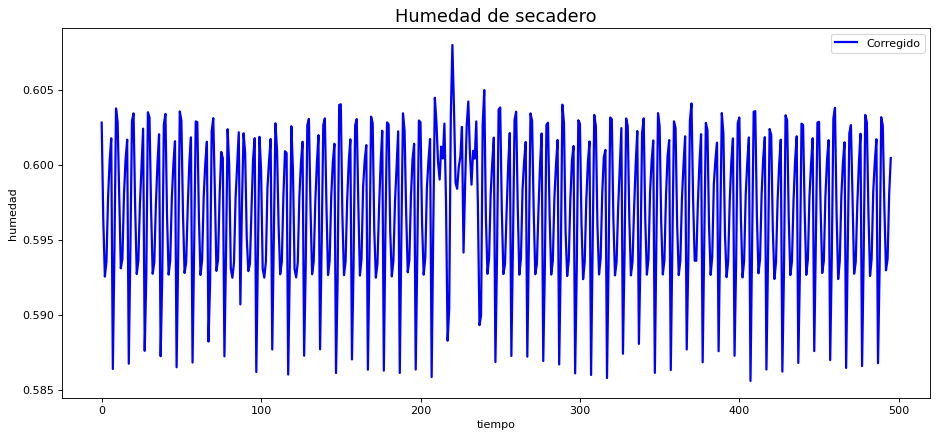

In [215]:
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(X_test_pred_seq[:,0,0].flatten(), 'b', label='Corregido', linewidth=2)
#ax.plot(testset["Sensor1_HumedadEntrada"], 'r', label='Medido', linewidth=2, alpha=0.6)
ax.set_title('Humedad de secadero', fontsize=16)
ax.set_ylabel('humedad')
ax.set_xlabel('tiempo')
ax.legend(loc='upper right')
plt.show()

--- Reporte de Clasificación ---
              precision    recall  f1-score   support

       False       0.86      0.98      0.91       409
        True       0.64      0.20      0.30        82

    accuracy                           0.85       491
   macro avg       0.75      0.59      0.61       491
weighted avg       0.82      0.85      0.81       491


--- Matriz de Confusión ---
[[400   9]
 [ 66  16]]

AUC ROC: 0.7997
AUC PR (Precision-Recall): 0.5077


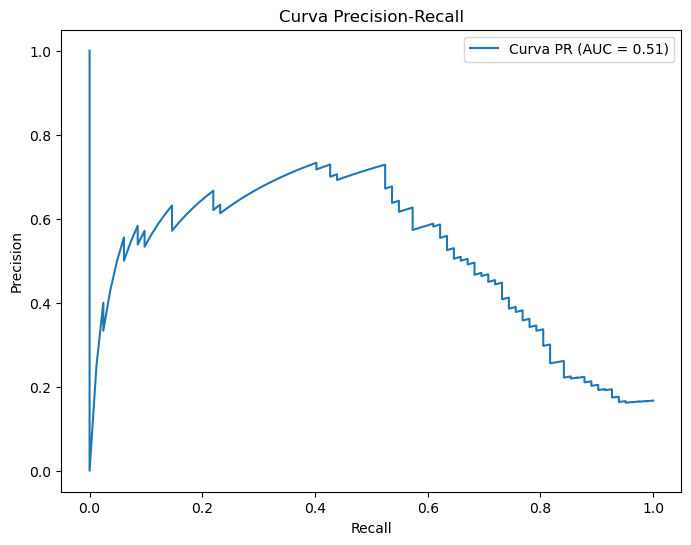

In [147]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve, auc

# Asegurarse de que las etiquetas 'Es_Anomalia' estén alineadas con las detecciones
y_true = df_test_analysis['Es_Anomalia'].values
y_pred_labels = df_test_analysis['Anomalia_Detectada'].values

print("--- Reporte de Clasificación ---")
print(classification_report(y_true, y_pred_labels, zero_division=0))

print("\n--- Matriz de Confusión ---")
print(confusion_matrix(y_true, y_pred_labels))

# Curva ROC y AUC (si los errores se pueden usar como scores)
# Para ROC AUC, necesitamos scores, no etiquetas binarias de predicción
# El error de reconstrucción puede servir como score.
if len(np.unique(y_true)) > 1: # Asegurarse de que hay ambas clases
    roc_auc = roc_auc_score(y_true, df_test_analysis['Reconstruction_Error'])
    print(f"\nAUC ROC: {roc_auc:.4f}")

    precision, recall, thresholds_pr = precision_recall_curve(y_true, df_test_analysis['Reconstruction_Error'])
    pr_auc = auc(recall, precision)
    print(f"AUC PR (Precision-Recall): {pr_auc:.4f}")

    plt.figure(figsize=(8,6))
    plt.plot(recall, precision, label=f'Curva PR (AUC = {pr_auc:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Curva Precision-Recall')
    plt.legend()
    plt.show()
else:
    print("\nNo se pueden calcular métricas AUC porque solo hay una clase en y_true (o no hay anomalías reales en la ventana analizada).")